In [2]:
DATASET_PATH = "../data/"
filename = "output.nmea"

data_src = DATASET_PATH + filename

In [3]:
import sys
sys.path.append('..')
from mapinmeters.extentutm import ExtentUTM
from mapinmeters.utils import nmea2df
import matplotlib.pyplot as plt
import tilemapbase

In [4]:
# Read data from NMEA file and create description variable
position_df = nmea2df(data_src)
desc = position_df.describe()
desc

,latitude,longitude,q,age,ns
count,51.000000,51.000000,51.0,0.0,51.0
mean,52.056453,-9.509728,1.0,NaN,12.0
std,0.000505,0.001492,0.0,NaN,0.0
min,52.055633,-9.512217,1.0,NaN,12.0
25%,52.056042,-9.510908,1.0,NaN,12.0
50%,52.056383,-9.509750,1.0,NaN,12.0
75%,52.056975,-9.508242,1.0,NaN,12.0
max,52.057250,-9.507417,1.0,NaN,12.0


In [5]:
# Initialise tilemapbase
tilemapbase.start_logging()
tilemapbase.init(create=True)
t = tilemapbase.tiles.build_OSM()

In [6]:
# Set tilemap limits (10% of the difference on each axis is added)
delta_lat = 0.1 * (desc.latitude["max"] - desc.latitude["min"])
delta_lon = 0.1 * (desc.longitude["max"] - desc.longitude["min"])

min_lon = desc.longitude["min"] - delta_lon
max_lon = desc.longitude["max"] + delta_lon
min_lat = desc.latitude["min"] - delta_lat
max_lat = desc.latitude["max"] + delta_lat

In [7]:
# Create the Proj command and the ExtentUTM instance
proj_cmd = "+proj=utm +zone=29U, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs"

extent_utm = ExtentUTM(min_lon,
                       max_lon,
                       min_lat,
                       max_lat,
                       proj_cmd)

In [8]:
# Project our position data (NMEA) to the UTM zone we are using
utm_x = []
utm_y = []

for i, r in position_df.iterrows():
    dx, dy = extent_utm.utm_project(r["longitude"],r["latitude"])    
    utm_x.append(dx)
    utm_y.append(dy)

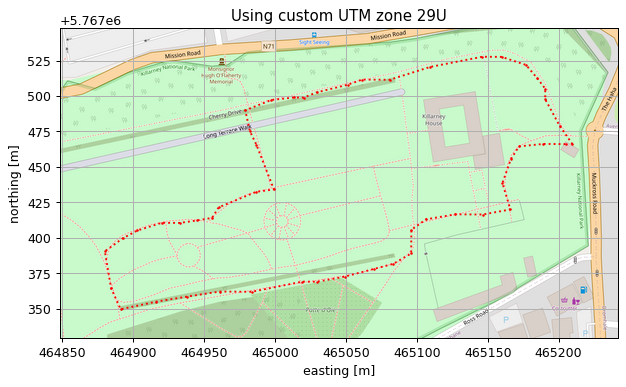

In [9]:
# Create the axes, plot the map and the data
# To use matplotlib as a widget uncomment the line below
# 
# %matplotlib widget

fig, axs = plt.subplots(1,1,figsize=(8,8), dpi=90)
tiles = t

plotter = tilemapbase.Plotter(extent_utm, tiles, width=600)
plotter.plot(axs, tiles)

axs.plot(utm_x, utm_y,":r.", label="data", markersize=2)

axs.set_title("Using custom UTM zone 29U")
axs.set_ylabel("northing [m]")
axs.set_xlabel("easting [m]")
axs.grid()

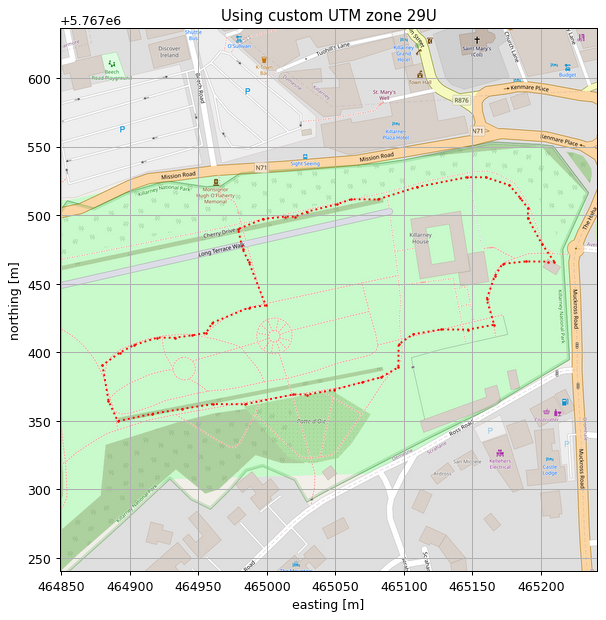

In [10]:
# Additionally, the data can be plotted using a square layout
# using the method ```.to_aspect()```

# %matplotlib widget

extent_utm_sq = extent_utm.to_aspect(1.0, shrink=False)

fig, axs = plt.subplots(1,1,figsize=(8,8), dpi=90)
tiles = t

plotter = tilemapbase.Plotter(extent_utm_sq, tiles, width=600)
plotter.plot(axs, tiles)

axs.plot(utm_x, utm_y,":r.", label="data", markersize=2)

axs.set_title("Using custom UTM zone 29U")
axs.set_ylabel("northing [m]")
axs.set_xlabel("easting [m]")
axs.grid()